# GradCAM Visualization of 50 misclassified images from the pre-trained ResNet18 Model trained on CIFAR10.

## Import libraries

In [1]:
# Import libraries
import numpy as np
import keras
import matplotlib.pyplot as plt
import time
import cv2
import keras.backend as K
from keras.utils import np_utils

Using TensorFlow backend.


## Install and load the model from [github package](https://github.com/qubvel/classification_models) for pretrained resnet18

In [2]:
!pip install image-classifiers

     |████████████████████████████████| 81kB 31.2MB/s 


In [3]:
from classification_models.resnet import ResNet18, preprocess_input
base_model = ResNet18((224, 224, 3), weights='imagenet', classes=10, include_top=False)

W0709 23:00:53.040295 139755102812032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0709 23:00:53.085441 139755102812032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0709 23:00:53.087271 139755102812032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0709 23:00:53.089063 139755102812032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0709 23:00:53.090239 139755

44924928/44920640 [==============================] - 5s 0us/step


## Downloading Dataset

In [4]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 13s 0us/step


## View Data

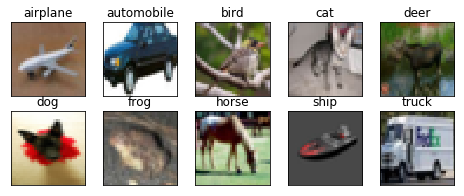

In [5]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

## Pixel Normalization and one-hot encoding

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255

train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

## Add a dense layer top to the pretrained model

In [7]:
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
x = keras.layers.Dropout(0.5)(x)
output = keras.layers.Dense(10, activation='softmax')(x)
model = keras.models.Model(inputs=[base_model.input], outputs=[output])

model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

W0709 23:01:34.208658 139755102812032 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0709 23:01:34.237062 139755102812032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



**Let's see the arch**

In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 224, 224, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn0 (Batch

**The last convolutional layer stage4_unit2_conv2, which is 6th before the final layer shall be used for visualization**

## Generator function to resize the images

**Instead of default 32 size of cifar10, we shall resize images to 224 to match the need of resnet18 network (gives better result).**

In [0]:
def image_generator(X, Y, batch_size=32):
  ind = 0
  while True:
    x = X[ind: ind + batch_size]
    y = Y[ind: ind + batch_size]
    ind += batch_size
    
    if ind > len(X):
      ind = 0
    
    batch_x = []
    batch_y = []
    
    for (i, j) in zip(x,y):
      x_upscaled = cv2.resize(i, (224, 224), interpolation=cv2.INTER_CUBIC)
      batch_x.append(x_upscaled)
      batch_y.append(j)
      
    yield (
        np.array(batch_x),
        np.array(batch_y))

## Model Re-Training

In [10]:
# Fit the model
history = model.fit_generator(image_generator(train_features, train_labels),
                              epochs = 5, 
                              steps_per_epoch= np.ceil(train_features.shape[0]/32),
                              verbose=1)

W0709 23:01:51.428967 139755102812032 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
1563/1563 [==============================] - 223s 143ms/step - loss: 0.6462 - acc: 0.7876
Epoch 2/5
1563/1563 [==============================] - 222s 142ms/step - loss: 0.2402 - acc: 0.9196
Epoch 3/5
1563/1563 [==============================] - 222s 142ms/step - loss: 0.1297 - acc: 0.9566
Epoch 4/5
1563/1563 [==============================] - 222s 142ms/step - loss: 0.0688 - acc: 0.9781
Epoch 5/5
1563/1563 [==============================] - 222s 142ms/step - loss: 0.0358 - acc: 0.9895


## Model Evaluation on Test Dataset

In [20]:
score = model.evaluate_generator(image_generator(test_features, test_labels),
                        steps = np.ceil(test_features.shape[0]/32),
                        verbose=1)
print("Validation Loss : ", score[0])
print("Validation Accuracy:", score[1]*100, "%")

313/313 [==============================] - 15s 46ms/step
Validation Loss :  0.21836905440613627
Validation Accuracy: 93.93 %


## GradCAM Visualization of 50 misclassified images

Let's define a function for heatmap of an image

In [0]:
def get_heatmap(image, class_idx):
  img = np.expand_dims(image, axis=0)
  img = preprocess_input(img)
  class_output = model.output[:, class_idx]
  last_conv_layer = model.layers[-6] 
  
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([img])
  for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[2]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  
  return heatmap

### Get the misclassified images

In [13]:
pred_valid = model.predict_generator(image_generator(test_features, test_labels), 
                                     steps= np.ceil(test_features.shape[0]/32), verbose=1)
pred_labels = np.argmax(pred_valid,axis=1)

labels = np.argmax(test_labels, axis=1)
mislabelled_index=[]

for i in range(labels.shape[0]):
  if pred_labels[i] != labels[i]:
    mislabelled_index.append(i)
print('Number of False predictions: ', len(mislabelled_index),'out of 10000')

313/313 [==============================] - 15s 49ms/step
Number of False predictions:  607 out of 10000


**Finally display the 50 misclassified images and their heatmaps**

Label: dog 
Predicted: deer


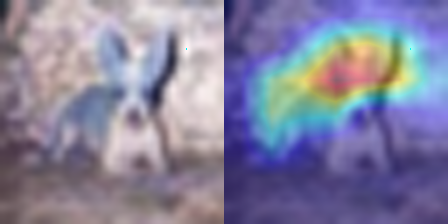

Label: dog 
Predicted: cat


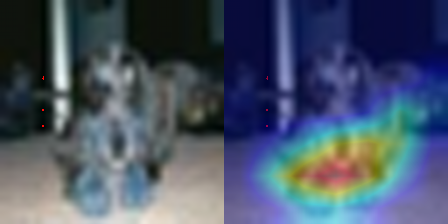

Label: frog 
Predicted: cat


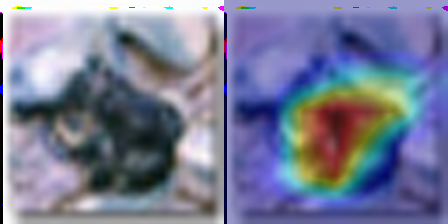

Label: horse 
Predicted: dog


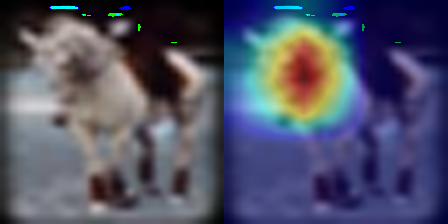

Label: horse 
Predicted: dog


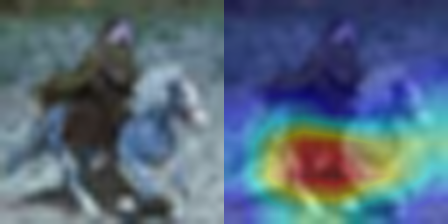

Label: bird 
Predicted: cat


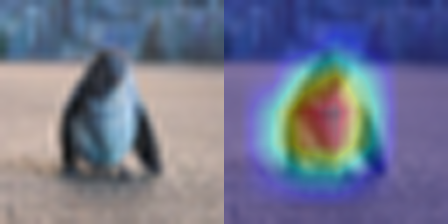

Label: cat 
Predicted: dog


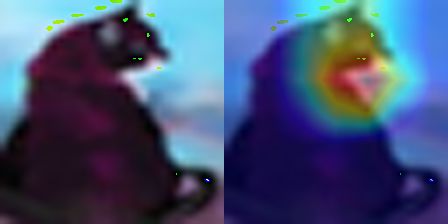

Label: deer 
Predicted: horse


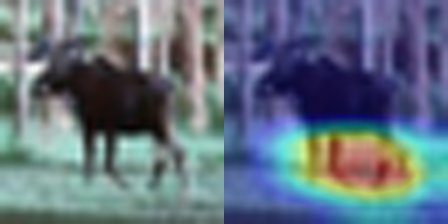

Label: cat 
Predicted: horse


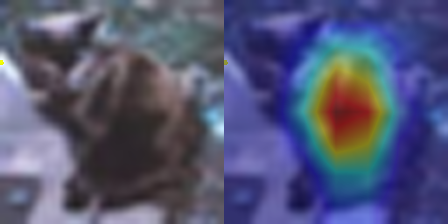

Label: horse 
Predicted: dog


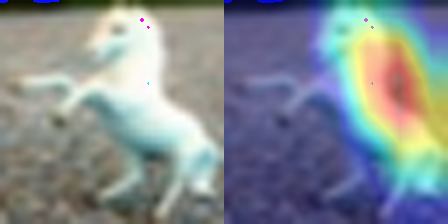

Label: cat 
Predicted: truck


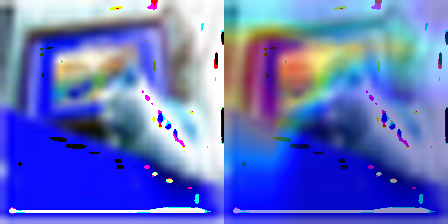

Label: truck 
Predicted: airplane


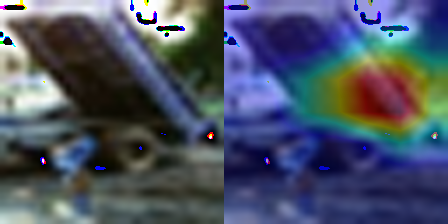

Label: dog 
Predicted: cat


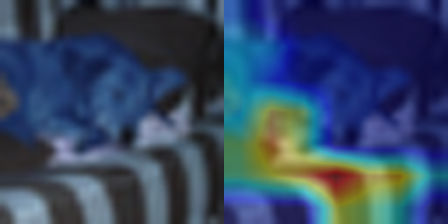

Label: truck 
Predicted: automobile


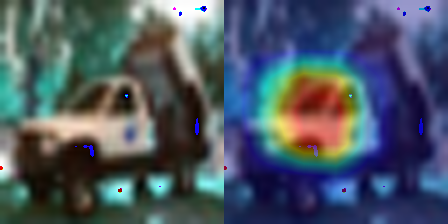

Label: dog 
Predicted: frog


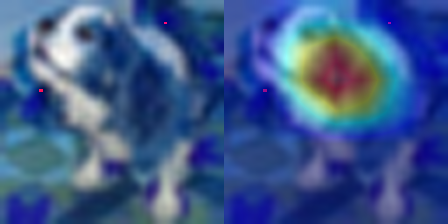

Label: automobile 
Predicted: truck


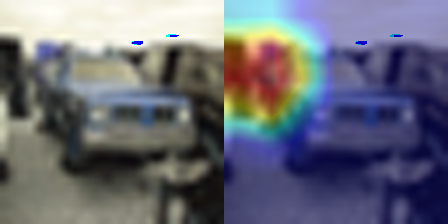

Label: deer 
Predicted: cat


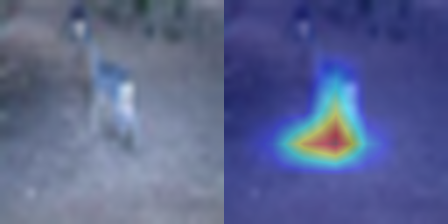

Label: automobile 
Predicted: truck


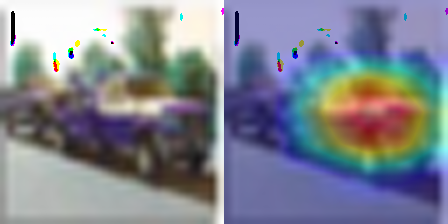

Label: airplane 
Predicted: ship


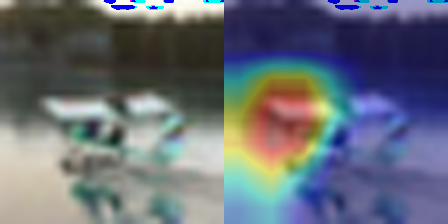

Label: dog 
Predicted: cat


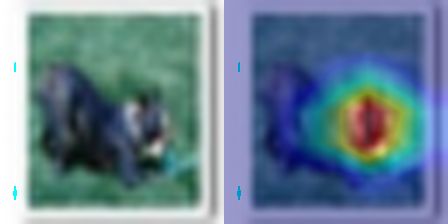

Label: automobile 
Predicted: ship


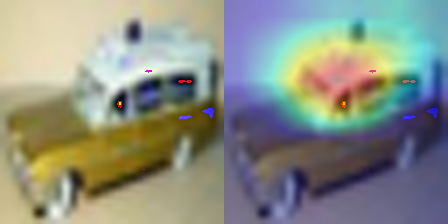

Label: bird 
Predicted: frog


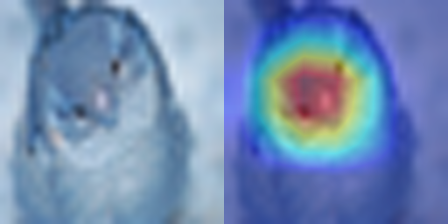

Label: dog 
Predicted: cat


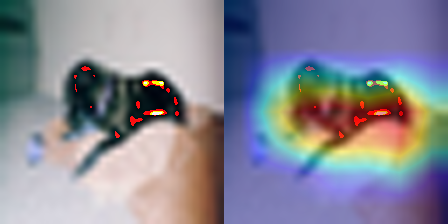

Label: truck 
Predicted: automobile


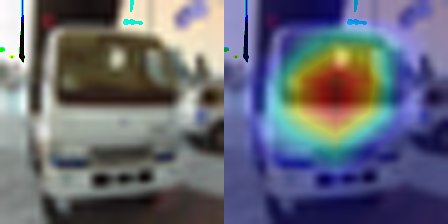

Label: cat 
Predicted: bird


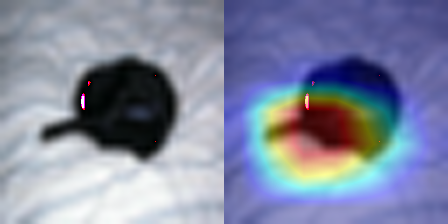

Label: bird 
Predicted: dog


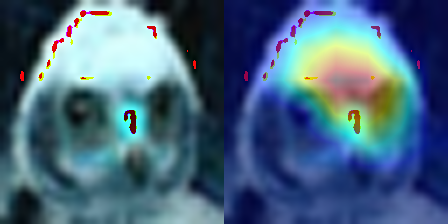

Label: cat 
Predicted: dog


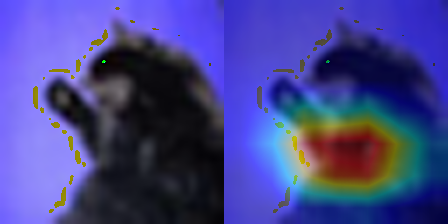

Label: bird 
Predicted: airplane


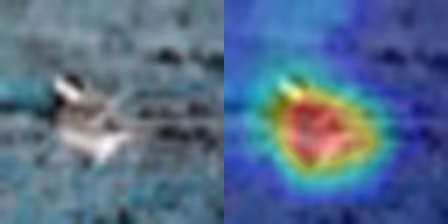

Label: frog 
Predicted: cat


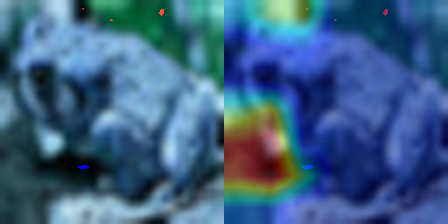

Label: truck 
Predicted: automobile


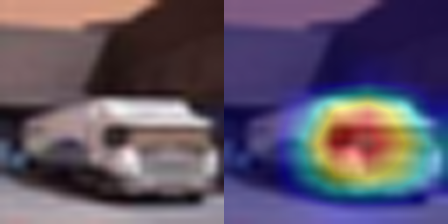

Label: deer 
Predicted: dog


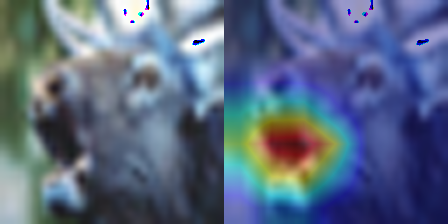

Label: dog 
Predicted: deer


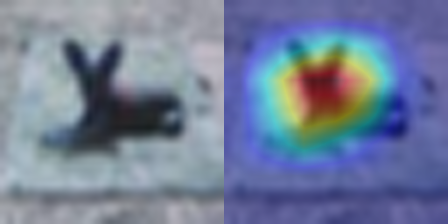

Label: deer 
Predicted: dog


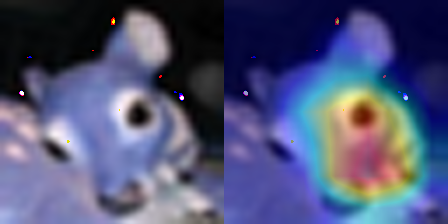

Label: cat 
Predicted: dog


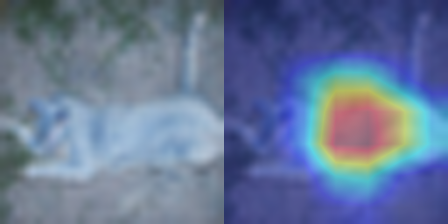

Label: deer 
Predicted: cat


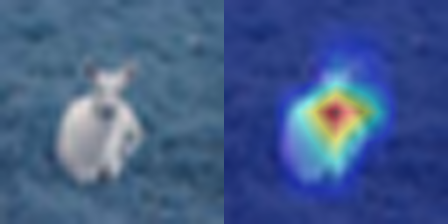

Label: cat 
Predicted: deer


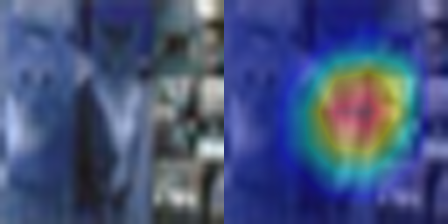

Label: automobile 
Predicted: airplane


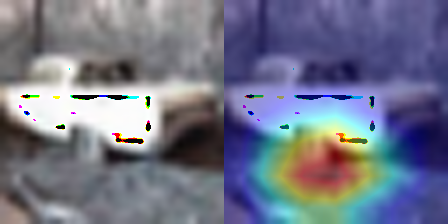

Label: deer 
Predicted: horse


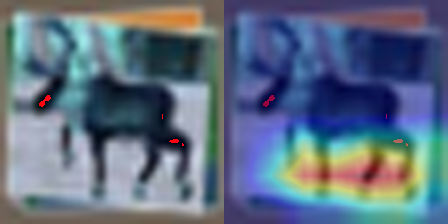

Label: cat 
Predicted: dog


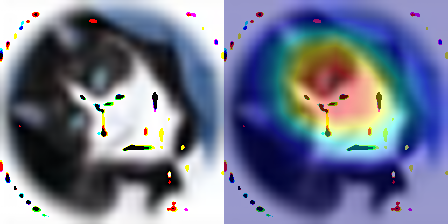

Label: automobile 
Predicted: truck


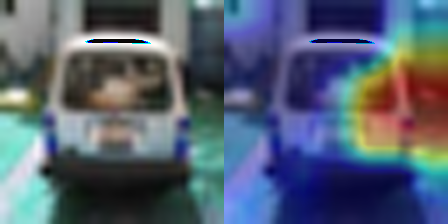

Label: frog 
Predicted: cat


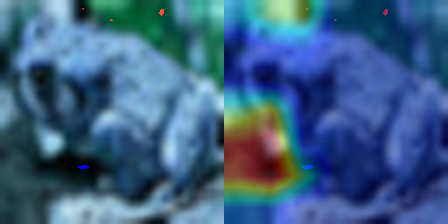

Label: dog 
Predicted: cat


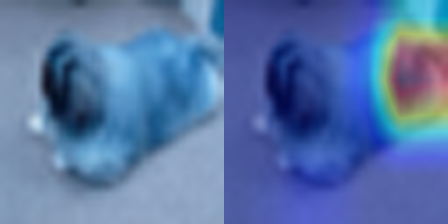

Label: bird 
Predicted: deer


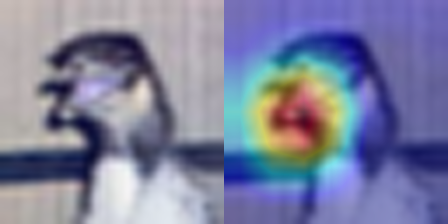

Label: bird 
Predicted: airplane


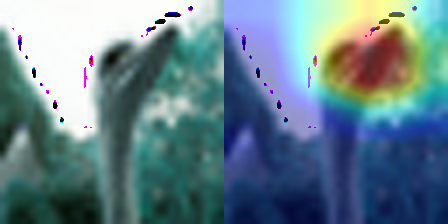

Label: cat 
Predicted: bird


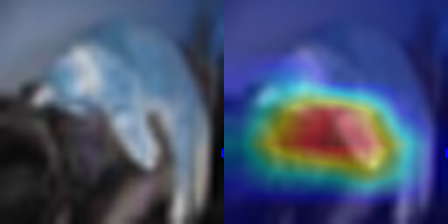

Label: airplane 
Predicted: ship


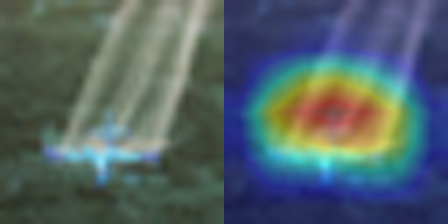

Label: truck 
Predicted: automobile


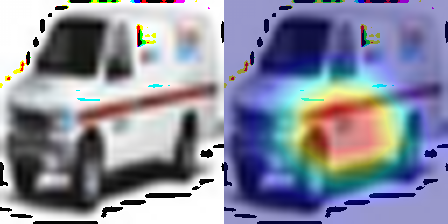

Label: airplane 
Predicted: ship


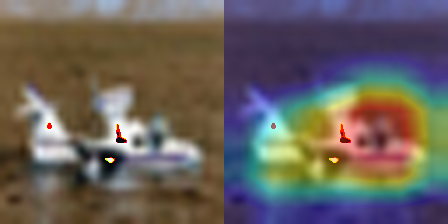

Label: cat 
Predicted: dog


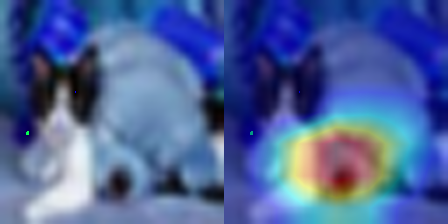

Label: cat 
Predicted: dog


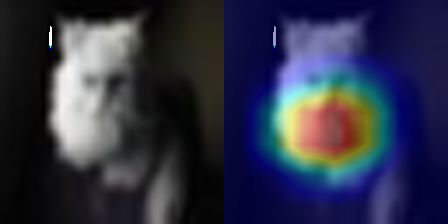

In [19]:
from google.colab.patches import cv2_imshow
#any random 50 out 607 mislabelled images
np.random.seed(1)
for id in np.random.choice(mislabelled_index,50): 

  image = cv2.resize(test_features[id], (224, 224), interpolation=cv2.INTER_CUBIC)
  label = pred_labels[id]

  heatmap = get_heatmap(image, label)
  image = np.uint8(255 * image)
  superimposed_img = cv2.addWeighted(image, 0.6, heatmap, 0.4, 0)
  concat_img = cv2.hconcat([image, superimposed_img])
  
  print('Label:', class_names[labels[id]],'\nPredicted:', class_names[pred_labels[id]])
  cv2_imshow(concat_img)
  cv2.waitKey(0)

**Comments: Few misclassifications are justified, but few are hillarious**